# Supervised identification of distribution overlaps.

In [1]:
import scipy
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift, estimate_bandwidth

import pandas as pd

from scipy import stats
from scipy.stats import beta
from math import sin
from random import randint

###########################################
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

import itertools as it

from matplotlib.collections import BrokenBarHCollection
import pandas as pd

import re

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
init_notebook_mode(connected=True)

import collections

def recursively_default_dict():
        return collections.defaultdict(recursively_default_dict)


In post **4. X material**, we examined how the density distribution of reference populations could be used to perform 3 tasks simultaneously:

- Classifiy unlabelled observations (into known classes or as outliers).
- Reclassify mislabelled observations if these occurences are not pervasive.
- Identify outlier material among labelled observations (we simulated a fourth, differentiated population).

The scenario we simulated was quite simple, in that our labelled reference populations and our unlabelled outlier population were neatly differentiated, facilitating our classification task.

In a following post (**5. visualizing KDE**), we simulated three populations, two of which periodically overlapped (we set their distance to be the sinusoid of a variable X which we then made to vary). We went on to explore how the sequencial un-supervised clustering of our data at varying values of X could be used to pinpoint those regions where sin(x) reached 0.

But how would we go about identifying cases where X == 0 using supervised learning alone?

Let's first simulate our moving populations. Again, three populations, two of which see their centers come together as a function of X (distance = sin(x)):


In [2]:
# @hidden_cell
## creating a stable pop:
cov_pop1= [[2,0,0],[0,1,0],[0,0,1]]
cov_pop2= [[1,0,0],[0,.3,0],[0,0,.1]]
cov_pop3= [[1,0,0],[0,.3,0],[0,0,.1]]

### Number of values:
Sizes= [80,100,30]
labels= [0,1,2]
label_vector= np.repeat(np.array([x for x in labels]),Sizes)
label_indicies= {x:[y for y in range(len(label_vector)) if label_vector[y] == x] for x in labels}

def jumpingJack(x):
    
    height= sin(x) * 5
    
    mean_pop1= [randint(-2,2),0,randint(-5,5)]
    mean_pop3= [0,10,height]
    mean_pop2= [0,10,-height]
    
    
    Pop1= np.random.multivariate_normal(mean_pop1, cov_pop1, Sizes[0])
    Pop2= np.random.multivariate_normal(mean_pop2, cov_pop2, Sizes[1])

    feature= np.vstack((Pop1,Pop2))
    
    Pop3= np.random.multivariate_normal(mean_pop3, cov_pop3, Sizes[2])

    data= np.vstack((feature,Pop3))

    fig_data= [go.Scatter3d(
            x = data[[x for x in range(sum(Sizes)) if label_vector[x] == i],0],
            y = data[[x for x in range(sum(Sizes)) if label_vector[x] == i],1],
            z = data[[x for x in range(sum(Sizes)) if label_vector[x] == i],2],
            type='scatter3d',
            mode= "markers",
            marker= {
            'line': {'width': 0},
            'size': 4,
            'symbol': 'circle',
          "opacity": .8
          },
          name= str(i)
        ) for i in labels]



    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    fig = go.Figure(data=fig_data, layout=layout)
    iplot(fig)

interact(jumpingJack,x=(0,30,1))

interactive(children=(IntSlider(value=15, description='x', max=30), Output()), _dom_classes=('widget-interact',))

<function __main__.jumpingJack>

Use the slider to vary X and see how it impacts the distance separating populations 1 and 2.


Now, we are going to have our variable X move between 0 and 30 and steps of .1. At each step, the kernel density of each of our populations will be estimated, and the value of each observation under each KDE will be extracted.

In [3]:

def extract_profiles(global_data,target_ind_dict):
    ## estimate the bandwith
    params = {'bandwidth': np.linspace(np.min(global_data), np.max(global_data),20)}
    grid = GridSearchCV(KernelDensity(algorithm = "ball_tree",breadth_first = False), params,verbose=0)
    
    cluster_profiles= {x:[] for x in target_ind_dict.keys()}
    
    
    ## perform MeanShift clustering.
    combine= {}
    for bull in target_ind_dict.keys():
        Quanted_set= global_data[target_ind_dict[bull],:]
        grid.fit(Quanted_set)
        kde = grid.best_estimator_

        P_dist = kde.score_samples(Quanted_set)
        Fist = kde.score_samples(global_data)

        ## Normalizing log-likelihood estimates by those of the reference set.
        Fist = scipy.stats.norm(np.mean(P_dist),np.std(P_dist)).cdf(Fist)
        cluster_profiles[bull].append(Fist)

    
    return cluster_profiles
    
    

def jumpingJack(x):
    height= sin(x) * 5
    
    mean_pop1= [randint(-2,2),0,randint(-5,5)]
    mean_pop3= [0,10,height]
    mean_pop2= [0,10,-height]
    
    
    Pop1= np.random.multivariate_normal(mean_pop1, cov_pop1, Sizes[0])
    Pop2= np.random.multivariate_normal(mean_pop2, cov_pop2, Sizes[1])

    feature= np.vstack((Pop1,Pop2))
    
    Pop3= np.random.multivariate_normal(mean_pop3, cov_pop3, Sizes[2])

    data= np.vstack((feature,Pop3))
    return data



In [4]:
# Varying 'X'. This can take a few minutes.

Windows= recursively_default_dict()

target_indx= {z:[x for x in range(len(label_vector)) if label_vector[x] == z] for z in list(set(label_vector))}
threshold= .005
P= 30

for window in np.arange(0.0, 30, .1):
    data = jumpingJack(window)
    
    profiles= extract_profiles(data,label_indicies)
    
    Windows[int(window*1000)]= profiles


Windows= {1:Windows}

### Supervised overlaps

We have extracted a likelihood value relative to each of our three populations for every point in our data set at every value of X.

In previous posts, we had resorted to one theshold only: the outlier threshold. This left all other observations to be classed to the group which provided them with the highest density value. This worked well because our initial populations being quite neat, and thus the differences between the densities obtained quite large. 

What if these differences are not so big, as in the case where two populations partially, or completely overlap?

We will resort to a second threshold now, a comparison threshold. We'll say: I want my observations to be classed as part of a group only if that group's density at that point was, for example, 3 times larger than either of the other two. Else, the observation will be classed as intermediate.

This serves us well in this case, because we only have 3 reference populations, resulting in 4 intermediate classes only.

Because of the added classes, we'll change the color scheme:

**pure classes**:
- pop1: red
- pop2: yellow
- pop3: blue

**Intermediate classes**
- pop0-pop1: orange
- pop1-pop2: green
- pop0-pop2: purple
- pop0-pop1-pop2: silver

The next block contains only functions and can be skipped.

Assignments at varying steps of X will be plotted as a global ideogram.

-  Comparison_threshold= 5
-  Outlier_threshold= 1e-4

In [5]:




def Merge_class(Ref_profiles,focus_indicies,Out,Diff_threshold,X_threshold):
    Blocks_genome = recursively_default_dict()
    
    for CHR in Ref_profiles.keys():
        print(CHR)
        Points = sorted(Out[CHR].keys())
        Likes = Ref_profiles[CHR]
        N_pops= len(Likes[[x for x in Likes.keys()][0]])
        Pop_labels= Likes[[x for x in Likes.keys()][0]].keys()
        print("number of reference populations: {0}".format(N_pops))
        Likes = {x:[Likes[bl][x] for bl in sorted(Likes.keys())] for x in Pop_labels}
        Likes = {x:np.array([y[0] for y in Likes[x]]) for x in Likes.keys()}

        Topo = []
        
        #range_Parents = [x + Aro.shape[0] for x in range(Daddy.shape[0])]
        #range_Crossed = [x for x in range(Aro.shape[0])]
        
        for acc in focus_indicies:
            Guys = np.array([Likes[x][:,acc] for x in Pop_labels])
            Guys = np.nan_to_num(Guys)
            Guys = [[[y,0][int(y<=X_threshold)] for y in x] for x in Guys]
            
            Test = [int(x <= X_threshold) for x in np.amax(np.array(Guys),axis = 0)]     
            
            #
            Guys = np.array(Guys).T
            
            maxim = np.argmax(Guys,axis = 1)
            where_X = [x for x in range(Guys.shape[0]) if Test[x] == 1]
            
            #
            Consex = [x for x in it.combinations(range(N_pops),2)]
            if Consex:
                for h in range(len(maxim)):
                    CL = []
                    for j in Consex:
                        Diff = Guys[h,j]
                        if maxim[h] not in j or len([x for x in Diff if x < X_threshold]) > 0:
                            continue
                        if max(Diff) <= X_threshold:
                            Diff = 0
                        else:
#                            Diff = int(len([x for x in Diff if x <= Diff_threshold]) == 1)
                            Diff = abs(max(Diff)) / abs(min(Diff))
                            Diff = int(Diff > Diff_threshold)
                        
                        if Diff == 0:
                            CL.append(j)
                    
                    if len(CL) == 2:
                        maxim[h] = 7
                    if len(CL) == 1:
                        maxim[h] = sum(CL[0]) + N_pops
            
            maxim[where_X] = N_pops
            
            if not Consex:
                for h in range(len(maxim)):
                    maxim[h] = int(10*Guys[h,0])    
            
            
            Topo.append(maxim + 1)
        
        
        Topo = np.array(Topo).T
        
        Clove = {CHR:{Points[x]:Topo[x,] for x in range(len(Points))}}
        
        Blocks_genome.update(Clove)
    
    return Blocks_genome


def compress_ideo(df,chromosome_list):
    
    new_set = []
    
    for CHR in range(len(chromosome_list)):
        
        Chr = int(re.search('Region_(.+?)_',chromosome_list[CHR]).group(1))
        sub = df[df.chrom == chromosome_list[CHR]]
        Coordinates = sorted(sub.start)
        Size = sub.shape[0]
        start = min(df.start)
        First = sub.gieStain.iloc[0]
        for index in range(len(Coordinates)):
            row = sub[sub.start == Coordinates[index]]
            if index == 0:
                continue
            if index == (Size - 1):
                if row.gieStain.iloc[0] == First:
                    new_set.append([chromosome_list[CHR],start,Out[Chr][max(df.start)],First])
                else:
                    new_set.append([chromosome_list[CHR],start,Out[Chr][max(df.start)],First])
                    First = row.gieStain.iloc[0]
                    start = row.start.iloc[0]
                    new_set.append([chromosome_list[CHR],start,Out[Chr][max(df.start)],First])
            else:
                if row.gieStain.iloc[0] == First:
                    continue
                else:
                    new_set.append([chromosome_list[CHR],start,row.start.iloc[0]-1,First])
                    First = row.gieStain.iloc[0]
                    start = row.start.iloc[0]
    
    new_set = pd.DataFrame(new_set,columns = ['chrom', 'start', 'end', 'gieStain'])
    return new_set


# Here's the function that we'll call for each dataframe (once for chromosome
# ideograms, once for genes).  The rest of this script will be prepping data
# for input to this function
#
def chromosome_collections(df, y_positions, height,  **kwargs):
    """
    Yields BrokenBarHCollection of features that can be added to an Axes
    object.
    Parameters
    ----------
    df : pandas.DataFrame
        Must at least have columns ['chrom', 'start', 'end', 'color']. If no
        column 'width', it will be calculated from start/end.
    y_positions : dict
        Keys are chromosomes, values are y-value at which to anchor the
        BrokenBarHCollection
    height : float
        Height of each BrokenBarHCollection
    Additional kwargs are passed to BrokenBarHCollection
    """
    del_width = False
    if 'width' not in df.columns:
        del_width = True
        df['width'] = df['end'] - df['start']
    for chrom, group in df.groupby('chrom'):
        
        yrange = (y_positions[chrom], height)
        xranges = group[['start', 'width']].values
        yield BrokenBarHCollection(
            xranges, yrange, facecolors=group['colors'], **kwargs)
    if del_width:
        del df['width']


def return_ideogram(ideo):
    # Height of each ideogram
    chrom_height = 1

    # Spacing between consecutive ideograms
    chrom_spacing = 0

    # Height of the gene track. Should be smaller than `chrom_spacing` in order to
    # fit correctly
    gene_height = 0.0

    # Padding between the top of a gene track and its corresponding ideogram
    gene_padding = 0.0


    # Keep track of the y positions for ideograms and genes for each chromosome,
    # and the center of each ideogram (which is where we'll put the ytick labels)
    ybase = 0
    chrom_ybase = {}
    gene_ybase = {}
    chrom_centers = {}

    # Iterate in reverse so that items in the beginning of `chromosome_list` will
    # appear at the top of the plot
    for chrom in chromosome_list[::-1]:
        chrom_ybase[chrom] = ybase
        chrom_centers[chrom] = ybase + chrom_height / 2.
        gene_ybase[chrom] = ybase - gene_height - gene_padding
        ybase += chrom_height + chrom_spacing



    # Keep track of the y positions for ideograms and genes for each chromosome,
    # and the center of each ideogram (which is where we'll put the ytick labels)
    ybase = 0
    chrom_ybase = {}
    gene_ybase = {}
    chrom_centers = {}

    # Iterate in reverse so that items in the beginning of `chromosome_list` will
    # appear at the top of the plot
    for chrom in chromosome_list[::-1]:
        chrom_ybase[chrom] = ybase
        chrom_centers[chrom] = ybase + chrom_height / 2.
        gene_ybase[chrom] = ybase - gene_height - gene_padding
        ybase += chrom_height + chrom_spacing
    

    # Colors for different chromosome stains
    color_lookup = {
        'red': [255, 0, 0],
        'yellow': [255, 255, 0],
        'blue': [0, 0, 255],
        'orange': [255, 165, 0],
        'green': [50, 205, 50],
        'black': [0, 0, 0],
        'purple': [128, 0, 128],
        'silver': [211, 211, 211],
    }

    # Add a new column for colors
    
    ideo['colors'] = ideo['gieStain'].apply(lambda x: tuple([round(y / float(255),1) for y in color_lookup[x]]))
    # Add a new column for width
    ideo['width'] = ideo.end - ideo.start

    # Width, height (in inches)
    figsize = (10, 30)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    # Now all we have to do is call our function for the ideogram data...
    print("adding ideograms...")
    for collection in chromosome_collections(ideo, chrom_ybase, chrom_height, edgecolors=None, linewidths= 0):
        ax.add_collection(collection)

    # Axes tweaking
    ax.set_xticks([x for x in range(min(ideo.start),max(ideo.end),int(1000))])
    plt.xticks(fontsize = 5,rotation = 90)
    ax.tick_params(axis = 'x',pad = 10)

    ax.tick_params(axis='y', which='major', pad=30)
    ax.set_yticks([chrom_centers[i] for i in chromosome_list])
    ax.set_yticklabels(chromosome_list, fontsize = 5)
    ax.axis('tight')
    return fig



In [6]:
Out= {y:{x:x + 99 for x in Windows[y].keys()} for y in Windows.keys()}
focus_indexes= [x for x in range(len(label_vector))]

Comparison_threshold= 5
Outlier_threshold= 1e-4

Blocks = Merge_class(Windows,focus_indexes,Out,Comparison_threshold,Outlier_threshold)

1
number of reference populations: 3


In [7]:



color_ref= ['red','yellow','blue','black','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

In [8]:
chromosome_list = []

Ideo = []

chromosomes= Blocks.keys()

for here in range(len(label_vector)):
    Subject = 'sample' + str(here)
    
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])
    
    Stock = [[['Region_'+str(Chr)+ '_' + Subject,bl,Out[Chr][bl],color_ref[Blocks[Chr][bl][here] - 1]] for bl in sorted(Blocks[Chr].keys())] for Chr in chromosomes]
    Stock = [y for y in it.chain(*[z for z in it.chain(*[Stock])])]
    
    Ideo.extend(Stock)


In [ ]:


#### begin by compressing assignments by individuals. Lightens the load of the following plot.
ideo = pd.DataFrame(Ideo,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

ideo = compress_ideo(ideo,chromosome_list)


adding ideograms...


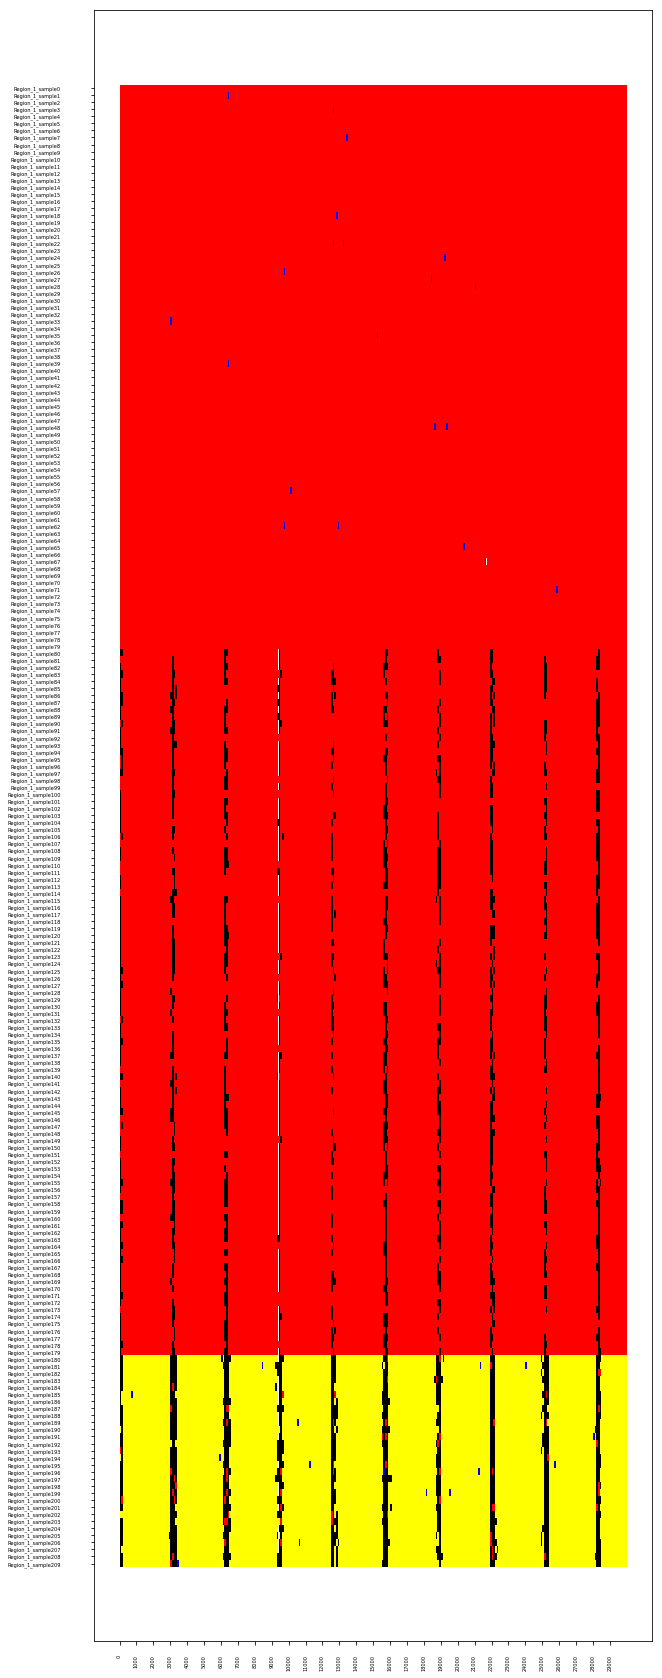

In [17]:
fig= return_ideogram(ideo)

